<a href="https://colab.research.google.com/github/pooriaazami/deep_learning_class_notebooks/blob/main/25_Double_Deep_Q_Learning_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Main source: https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

In [1]:
!pip install -q gymnasium[classic_control]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 4.4 MB/s eta 0:00:00


In [2]:
import math
import random
from collections import namedtuple, deque
from itertools import count

import gymnasium as gym

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from IPython import display

import numpy as np
import matplotlib.pyplot as plt

In [3]:
env = gym.make('CartPole-v1')

In [4]:
BATCH_SIZE = 128
NUM_EPISODES = 600

GAMMA = .99 # Discount factor

# epsilon-greedy parameters:
EPS_START = .9
EPS_END = .05
EPS_DECAY = 1000

TAU = 5e-3

LR = 1e-4
CLIP_VALUE = 100

MEMORY_SIZE = 10000

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
state, info = env.reset()
N_OBSERVATIONS = len(state)
N_ACTIONS = env.action_space.n

In [6]:
plt.ion()

In [7]:
MemoryBlock = namedtuple('MemoryBlock', ('state', 'action', 'reward', 'next_state'))

class ReplayMemory:
  def __init__(self, capacity):
    self.memory = deque(maxlen=capacity)

  def __len__(self):
    return len(self.memory)

  def push(self, state, action, reward, next_state):
    block = MemoryBlock(state, action, reward, next_state)
    self.memory.append(block)

  def sample(self, batch_size):
    return random.sample(self.memory, batch_size)

In [8]:
class PolicyNetwork(nn.Module):
  def __init__(self, n_observations, n_actions, latent_dim=128):
    super().__init__()

    self.layers = nn.Sequential(
        nn.Linear(n_observations, latent_dim),
        nn.ReLU(),
        nn.Linear(latent_dim, latent_dim),
        nn.ReLU(),
        nn.Linear(latent_dim, n_actions)
    )

  def forward(self, x):
    return self.layers(x)

In [9]:
policy_net = PolicyNetwork(N_OBSERVATIONS, N_ACTIONS).to(DEVICE)
target_net = PolicyNetwork(N_OBSERVATIONS, N_ACTIONS).to(DEVICE)

target_net.load_state_dict(policy_net.state_dict())

<All keys matched successfully>

In [10]:
optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
criterion = nn.SmoothL1Loss()

In [11]:
memory = ReplayMemory(MEMORY_SIZE)

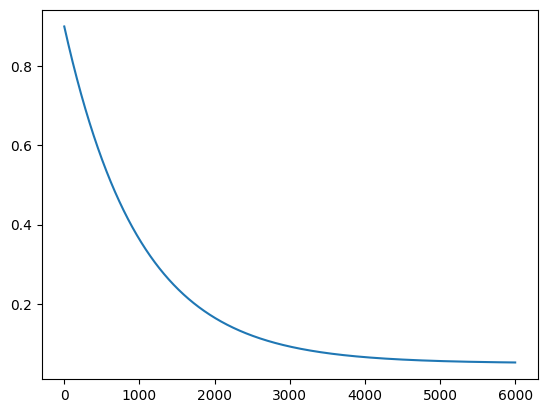

In [12]:
x = np.array(range(6000))

eps = EPS_END + (EPS_START - EPS_END) * np.exp(-1 * x / EPS_DECAY)

plt.plot(x, eps)
plt.show()

In [13]:
steps_done = 0

def select_action(state):
  global steps_done

  eps = EPS_END + (EPS_START - EPS_END) * math.exp(-1 * steps_done / EPS_DECAY)
  steps_done += 1

  if random.random() > eps:
    with torch.no_grad():
      action = policy_net(state).max(1).indices.view(1, 1)
  else:
    action = torch.tensor([[env.action_space.sample()]], device=DEVICE, dtype=torch.long)

  return action

In [14]:
def optimize_model():
  if len(memory) < BATCH_SIZE:
    return

  optimizer.zero_grad()

  history = memory.sample(BATCH_SIZE)
  batch = MemoryBlock(*zip(*history))

  state_batch = torch.cat(batch.state)
  action_batch = torch.cat(batch.action)
  reward_batch = torch.cat(batch.reward)

  state_action_values = policy_net(state_batch).gather(1, action_batch)

  non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=DEVICE, dtype=torch.bool)
  non_final_next_state = torch.cat([s for s in batch.next_state if s is not None])
  next_state_values = torch.zeros(BATCH_SIZE, device=DEVICE)

  with torch.no_grad():
    next_state_values[non_final_mask] = target_net(non_final_next_state).max(1).values

  expected_state_action_values = (next_state_values * GAMMA) + reward_batch
  loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

  loss.backward()

  nn.utils.clip_grad_value_(policy_net.parameters(), CLIP_VALUE)
  optimizer.step()

In [15]:
episode_durations = []

In [16]:
for epoch in range(1, NUM_EPISODES + 1):
  state, _ = env.reset()
  state = torch.tensor(state, dtype=torch.float32, device=DEVICE).unsqueeze(0)

  for t in count():
    action = select_action(state)

    observation, reward, terminated, truncated, _ = env.step(action.item())
    reward = torch.tensor([reward], device=DEVICE)

    if terminated:
      next_state = None
    else:
      next_state = torch.tensor(observation, dtype=torch.float32, device=DEVICE).unsqueeze(0)

    memory.push(state, action, reward, next_state)
    state = next_state

    optimize_model()

    target_state_dict = target_net.state_dict()
    policy_state_dict = policy_net.state_dict()

    for key in policy_state_dict:
      target_state_dict[key] = policy_state_dict[key] * TAU + target_state_dict[key] * (1 - TAU)

    target_net.load_state_dict(target_state_dict)

    if terminated or truncated:
      episode_durations.append(t + 1)

      if epoch % 50 == 0:
        print(f'Episode {epoch} duration: {t + 1}')

      break

Episode 50 duration: 10
Episode 100 duration: 17
Episode 150 duration: 8
Episode 200 duration: 74
Episode 250 duration: 119
Episode 300 duration: 120
Episode 350 duration: 145
Episode 400 duration: 181
Episode 450 duration: 318
Episode 500 duration: 500
Episode 550 duration: 500
Episode 600 duration: 500


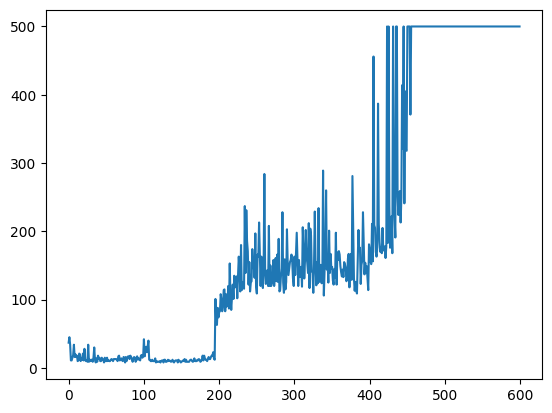

In [17]:
plt.plot(episode_durations)

plt.show()